In [24]:
%reload_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import fppnpx as fn
from fppnpx.ChannelSignal import ChannelSignal
from fppnpx.FPPGLM import FPPGLM
from fppnpx.signalfuncs import load_signal, gen_all_channel_signals
from wavemapnpx.WaveMAPClassifier import WaveMAPClassifier

from plottools import WAVEMAP_PAL, ml_map, cmap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
apath = "/Users/mateouma/Downloads/monkey datasets/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap-001.bin"
cpath = "/Users/mateouma/Downloads/monkey datasets/cluster_info_task.tsv"
wpath = "/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,123] # [204,209] # 

Nt = int(fs * (time_window[1] - time_window[0]))

signal_dataset = load_signal(appath=apath, time_window=time_window, fs=fs, cipath=cpath, wfpath=wpath)
channel_signals = gen_all_channel_signals(signal_dataset)

Generated 112 channel signals.


In [27]:
from numpy.lib.stride_tricks import sliding_window_view

def calculate_unit_firing_rate(chanID, unitID, fs, window_size=0.5, step_size=0.5):
    twindow = int(window_size * fs)
    tstep = int(step_size * fs)

    unit_spk_train = np.zeros(Nt)
    unit_spk_train[channel_signals[chanID].spike_times[unitID].astype(int)] = 1
    unit_spk_train_windowed = sliding_window_view(unit_spk_train, window_shape=twindow)
    unit_firing_rate = unit_spk_train_windowed[::tstep].sum(axis=1) / window_size

    return unit_firing_rate

def calculate_ts_firing_rate(spk_train, fs, window_size=0.5, step_size=0.5):
    twindow = int(window_size * fs)
    tstep = int(step_size * fs)

    spk_train_windowed = sliding_window_view(spk_train, window_shape=twindow)
    firing_rate = spk_train_windowed[::tstep].sum(axis=1) / window_size

    return firing_rate

def calculate_firing_rates(spike_trains, fs, window_size=0.5, step_size=0.5, cluster_labels=None):
    cluster_firing_rates = []
    cluster_mean_firing_rates = []
    cluster_ste_firing_rates = []

    twindow = int(window_size * fs)
    tstep = int(step_size * fs)
    
    if cluster_labels is not None:
        cluster_lab_dir = np.unique(cluster_labels)
        N_clust = cluster_lab_dir.size

        cluster_mask = [np.where(cluster_labels == cl)[0] for cl in cluster_lab_dir]
    else:
        N_clust = 1
        cluster_mask = [np.arange(spike_trains.shape[1])]

    for cl in range(N_clust):
        cluster_spk_trains = spike_trains[:,cluster_mask[cl]]

        windowed_spk_trains = sliding_window_view(cluster_spk_trains, window_shape=twindow, axis=0)
        firing_rates = windowed_spk_trains[::tstep].sum(axis=2) / window_size

        cluster_firing_rates.append(firing_rates.sum(axis=1))
        cluster_mean_firing_rates.append(firing_rates.mean(axis=1))
        cluster_ste_firing_rates.append(firing_rates.std(axis=1) / np.sqrt(firing_rates.shape[1]))

    if cluster_labels is None:
        cluster_firing_rates = cluster_firing_rates[0]
        cluster_mean_firing_rates = cluster_mean_firing_rates[0]
        cluster_ste_firing_rates = cluster_ste_firing_rates[0]

    return cluster_firing_rates, cluster_mean_firing_rates, cluster_ste_firing_rates

In [28]:
u374fr = calculate_unit_firing_rate('ch205', 374, fs)
u375fr = calculate_unit_firing_rate('ch205', 375, fs)
u378fr = calculate_unit_firing_rate('ch208', 378, fs)
u379fr = calculate_unit_firing_rate('ch208', 379, fs)
u380fr = calculate_unit_firing_rate('ch209', 380, fs)
u383fr = calculate_unit_firing_rate('ch212', 383, fs)

In [29]:
fr_time = np.arange(time_window[0], time_window[1], 0.5)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(fr_time, np.sum([u374fr, u375fr, u378fr, u379fr, u380fr, u383fr], axis=0))

In [38]:
u286fr = calculate_unit_firing_rate('ch162', 286, fs)
u287fr = calculate_unit_firing_rate('ch160', 287, fs)
u291fr = calculate_unit_firing_rate('ch160', 291, fs)
u292fr = calculate_unit_firing_rate('ch160', 292, fs)
u296fr = calculate_unit_firing_rate('ch163', 296, fs)
u298fr = calculate_unit_firing_rate('ch166', 298, fs)

In [39]:
Nt = channel_signals["ch13"].time_axis.size # number of time points
Nu = signal_dataset['units'].size # number of units

spike_trains_unsorted = np.zeros((Nt, Nu))
units_unsorted = []

u_idx = 0
for ch,ch_sig in channel_signals.items():
    for u, spktimes in ch_sig.spike_times.items():
        spike_trains_unsorted[spktimes.astype(int),u_idx] = 1
        units_unsorted.append(u)
        u_idx += 1

spike_trains = spike_trains_unsorted[:,np.argsort(units_unsorted)]

In [40]:
pop_frs,mean_pop_frs,__ = calculate_firing_rates(spike_trains, fs)

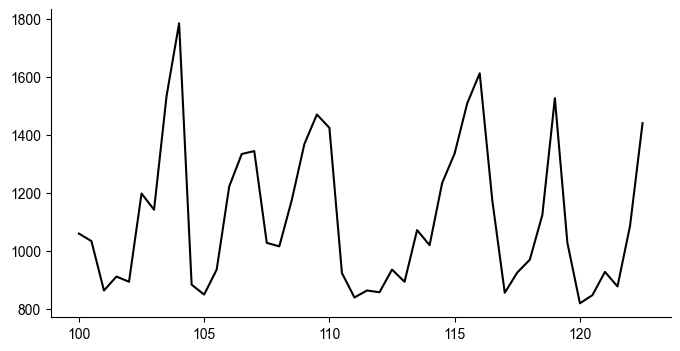

In [41]:
plt.figure(figsize=(8,4))
plt.plot(fr_time, pop_frs, color='k')

In [42]:
u378_instances,u378_filters,theor_freqs = channel_signals['ch208'].generate_unit_filters(selected_unit=378)
u379_instances,u379_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=379)
u374_instances,u374_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=374)
u375_instances,u375_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=375)
u380_instances,u380_filters,_ = channel_signals['ch209'].generate_unit_filters(selected_unit=380)
u383_instances,u383_filters,_ = channel_signals['ch212'].generate_unit_filters(selected_unit=383)

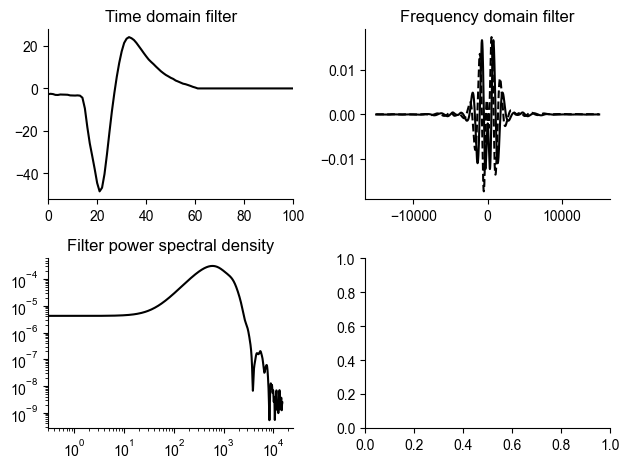

In [43]:
fn.filterfuncs.plot_filters(u379_filters['average_waveform']['time_filter'],
                            u379_filters['average_waveform']['freq_filter'],
                            u379_filters['average_waveform']['filter_psd'], theor_freqs)

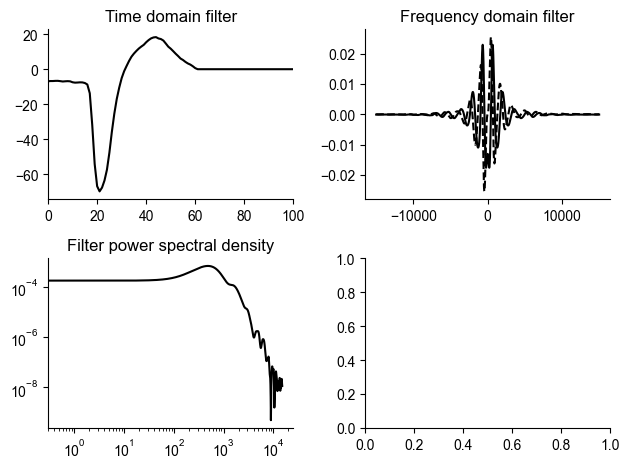

In [44]:
fn.filterfuncs.plot_filters(u383_filters['average_waveform']['time_filter'],
                            u383_filters['average_waveform']['freq_filter'],
                            u383_filters['average_waveform']['filter_psd'], theor_freqs)

In [36]:
signal_dataset['units']

array([ 17,  21,  22,  24,  35,  41,  48,  52,  64,  65,  80,  87,  91,
        95, 105, 116, 117, 123, 125, 129, 130, 135, 139, 140, 146, 150,
       153, 177, 213, 215, 227, 234, 239, 241, 247, 248, 249, 250, 251,
       255, 257, 260, 263, 265, 268, 269, 272, 274, 275, 278, 284, 286,
       287, 291, 292, 296, 298, 306, 310, 311, 313, 314, 315, 317, 322,
       323, 328, 329, 332, 333, 335, 336, 339, 340, 344, 346, 347, 348,
       350, 354, 356, 360, 362, 365, 374, 375, 378, 379, 380, 383, 389,
       392, 393, 396, 397, 398, 401, 403, 405, 410, 417, 418, 419, 423,
       429, 433, 435, 439, 441, 443, 447, 449, 469, 470, 473, 480, 491,
       496, 500, 502, 516, 519, 523, 526, 528, 530, 531, 539, 548, 552,
       554, 556, 557, 561, 572, 583, 585, 587])

In [35]:
wavemap_labels = np.load("chkdelay_dlpfc_0630_wavemap_clusters_0521_res_1.npy")
wavemap_labels

array([0, 1, 0, 6, 0, 6, 5, 6, 6, 6, 6, 5, 4, 5, 0, 1, 0, 5, 4, 2, 0, 5,
       2, 0, 0, 0, 6, 5, 3, 6, 4, 0, 2, 4, 0, 6, 4, 2, 1, 3, 4, 0, 0, 1,
       1, 2, 0, 4, 6, 4, 6, 4, 6, 4, 0, 1, 1, 1, 1, 4, 2, 1, 0, 1, 2, 1,
       4, 3, 2, 4, 1, 2, 2, 2, 2, 5, 2, 2, 2, 1, 6, 1, 2, 0, 0, 4, 0, 1,
       1, 5, 3, 4, 6, 4, 4, 0, 0, 3, 1, 0, 4, 0, 1, 4, 0, 1, 6, 0, 5, 5,
       0, 0, 5, 3, 5, 5, 0, 2, 3, 6, 3, 6, 6, 3, 3, 6, 3, 3, 3, 6, 6, 6,
       6, 2, 2, 5, 2, 5])

In [37]:
u_indices = np.array([np.where(signal_dataset['units'] == unit)[0] for unit in [378,379,374,380,383]])

print(signal_dataset['units'][u_indices])
print(wavemap_labels[u_indices])

[[378]
 [379]
 [374]
 [380]
 [383]]
[[0]
 [1]
 [0]
 [1]
 [5]]


In [45]:
wavemap_wfs_raw = np.load("wavemap_mean_waveforms_raw.npy")
wavemap_wfs_sc = np.load("wavemap_mean_waveforms_scaled.npy")

In [46]:
wavemap_psds_raw = np.load("wavemap_mean_psds_raw.npy")
wavemap_psds_sc = np.load("wavemap_mean_psds_scaled.npy")
wavemap_freqs = np.load("wavemap_freq_axis.npy")

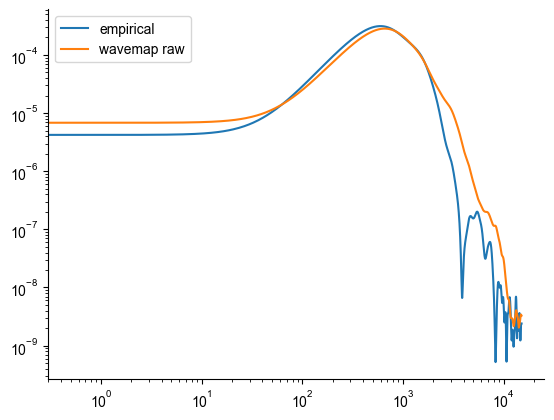

In [47]:
plt.loglog(theor_freqs, u379_filters['average_waveform']['filter_psd'], label='empirical')
plt.loglog(wavemap_freqs, wavemap_psds_raw[1], label='wavemap raw')
plt.legend()

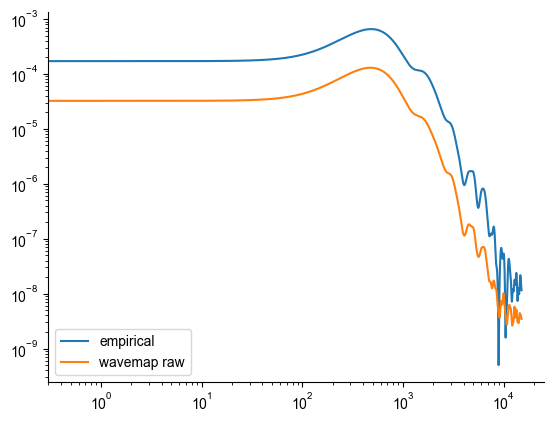

In [48]:
plt.loglog(theor_freqs, u383_filters['average_waveform']['filter_psd'], label='empirical')
plt.loglog(wavemap_freqs, wavemap_psds_raw[5], label='wavemap raw')
plt.legend()

In [ ]:
ts_signal = np.zeros_like(channel_signals['ch208'].time_series)

# u379_spktrain = np.zeros_like(channel_signals['ch208'].time_series)
# u379_spktrain[channel_signals['ch208'].spike_times[379].astype(int)] = 1

# u383_spktrain = np.zeros_like(channel_signals['ch212'].time_series)
# u383_spktrain[channel_signals['ch212'].spike_times[383].astype(int)] = 1

# ns2_sig = np.convolve(u379_spktrain, wavemap_wfs_raw[1])[20:-41] # NS-2
# bs2_sig = np.convolve(u383_spktrain, wavemap_wfs_raw[5])[20:-41] # BS-1

# ts_signal += ns2_sig
# ts_signal += bs2_sig

u378_spktrain = np.zeros_like(ts_signal)
u378_spktrain[channel_signals['ch208'].spike_times[378].astype(int)] = 1
u378_sig = np.convolve(u378_spktrain, u378_filters['average_waveform']['time_filter'][:62])[20:-41]

u380_spktrain = np.zeros_like(ts_signal)
u380_spktrain[]

(111.0, 112.5)

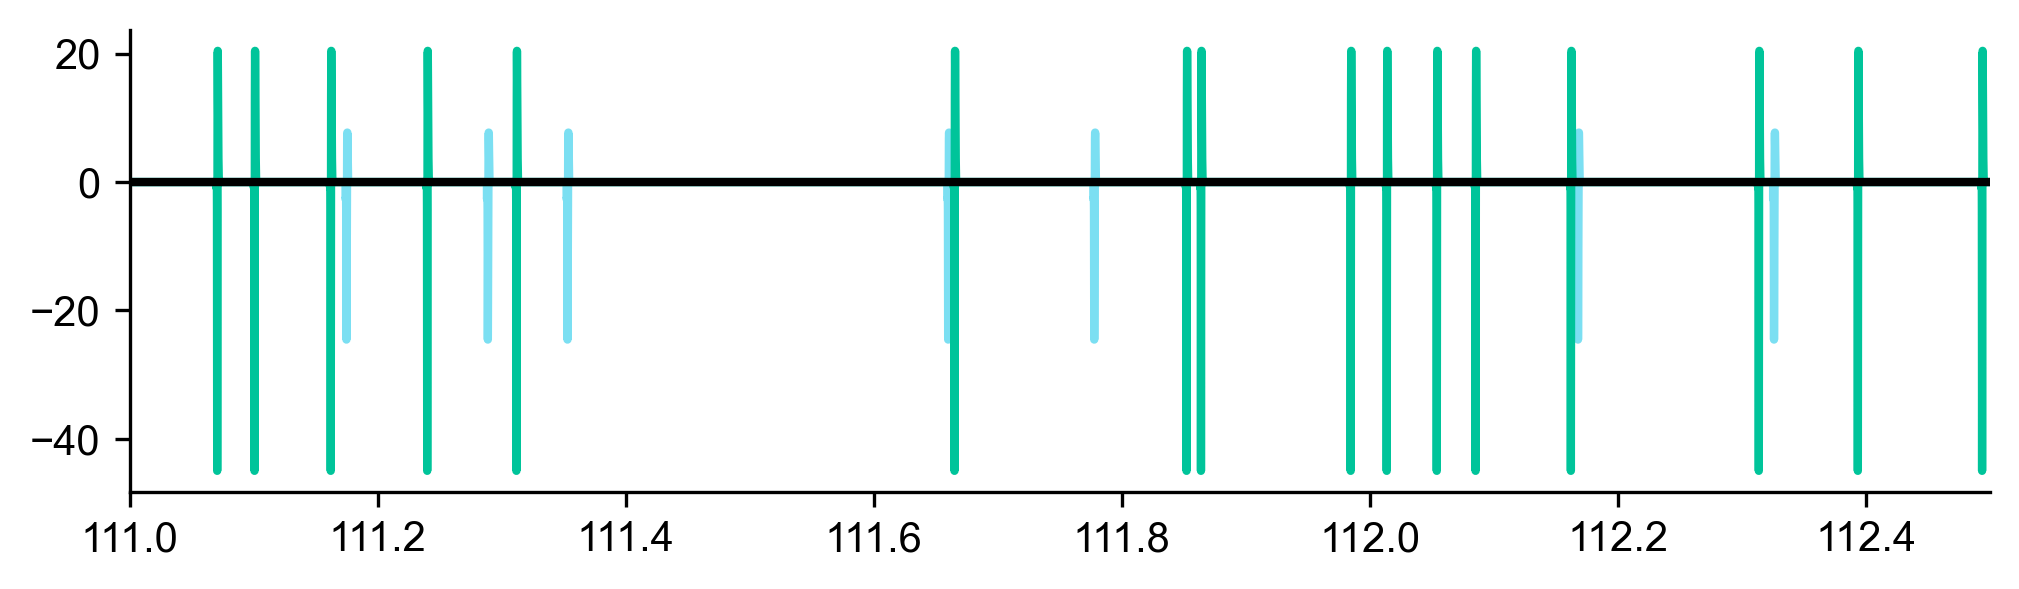

In [163]:
fig, ax = plt.subplots(figsize=(8,2), dpi=300)
# plt.plot(channel_signals['ch208'].time_axis, ts_signal, linewidth=2, color='k')
plt.plot(channel_signals['ch208'].time_axis, bs2_sig, linewidth=2, color=WAVEMAP_PAL[5])
plt.plot(channel_signals['ch208'].time_axis, ns2_sig, linewidth=2, color=WAVEMAP_PAL[1])
plt.plot(channel_signals['ch208'].time_axis, np.zeros_like(bs2_sig), linewidth=2, color='k')
plt.xlim(111,112.5) 

In [164]:
fig.savefig('figs/sim_2spks.svg', dpi=300)

(111.05, 111.4)

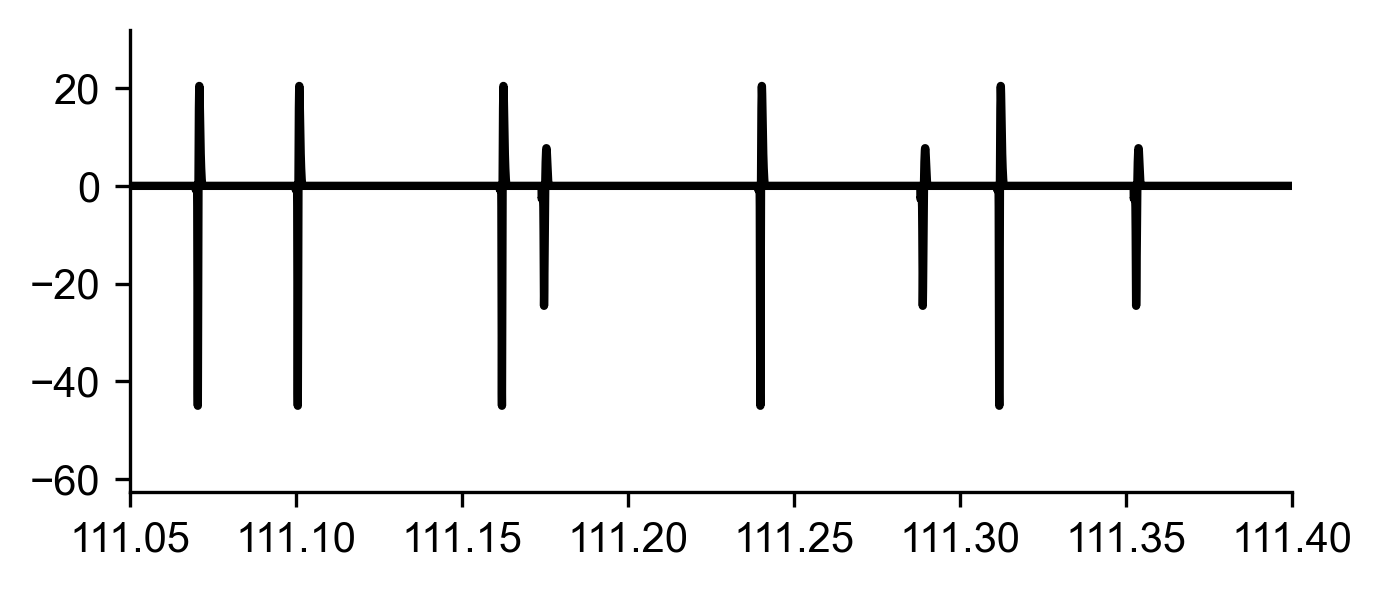

In [155]:
fig, ax = plt.subplots(figsize=(5,2), dpi=300)
plt.plot(channel_signals['ch208'].time_axis, ts_signal, linewidth=2, color='k')
plt.xlim(111.05,111.4)

In [ ]:
# # wavemap label 1 (NS-2)
# individual_spk_arr = np.zeros((channel_signals['ch208'].spike_times[379].size, fs*(time_window[1]-time_window[0])))

# nspks = len(u379_instances['waveforms'])

# # this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# # but i already wrote this once i realized
# for i,spk_time in enumerate(channel_signals['ch208'].spike_times[379].astype(int)):
#     if spk_time < 20:
#         continue

#     if i >= nspks:
#         break

#     individual_spk_arr[i,spk_time] = 1

#     exact_spk_instance = np.convolve(individual_spk_arr[i], u379_instances['waveforms'][i])

#     individual_spk_arr[i] = exact_spk_instance[20:-41]

# exact_spks = np.sum(individual_spk_arr, axis=0)

In [ ]:
# # wavemap label 5 (BS-2)
# individual_spk_arr2 = np.zeros((channel_signals['ch212'].spike_times[383].size, fs*(time_window[1]-time_window[0])))

# nspks = len(u383_instances['waveforms'])

# # this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# # but i already wrote this once i realized
# for i,spk_time in enumerate(channel_signals['ch212'].spike_times[383].astype(int)):
#     if spk_time < 20:
#         continue

#     if i >= nspks:
#         break

#     individual_spk_arr2[i,spk_time] = 1

#     exact_spk_instance = np.convolve(individual_spk_arr2[i], u383_instances['waveforms'][i])

#     individual_spk_arr2[i] = exact_spk_instance[20:-41]

# exact_spks2 = np.sum(individual_spk_arr2, axis=0)

In [ ]:
# ts_signal = exact_spks + exact_spks2

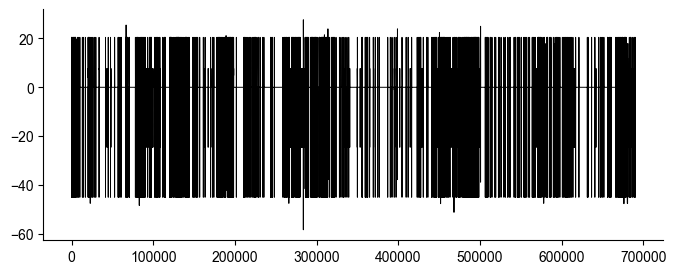

In [42]:
plt.figure(figsize=(8,3))
plt.plot(ts_signal, color='k', linewidth=0.7)

In [43]:
from fppnpx.FPPSSM import FPPSSM

Model instantiated


In [46]:
# ssm_filters = [u379_filters['waveform_instance']['filter_psd'],
#                u383_filters['average_waveform']['filter_psd']]

ssm_filters = [wavemap_psds_raw[1],
               wavemap_psds_raw[5]]

In [47]:
fppssm_full = FPPSSM(ts_signal, channel_signals['ch208'].time_axis, fs)

In [112]:
fppssm_full.fit_mv(ssm_filters, theor_freqs, 20)

Instantiating model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_2, sigma, d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, d_10, d_11, d_12, d_13, d_14, d_15, d_16, d_17, d_18, d_19, d_20, d_21, d_22, d_23, d_24, d_25, d_26, d_27, d_28, d_29, d_30, d_31, d_32, d_33, d_34, d_35, d_36, d_37, d_38, d_39, d_40, d_41, d_42, d_43, d_44, d_45]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1256 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [118]:
# u1_spktrain = np.zeros(Nt)

# for i,spk_time in enumerate(channel_signals['ch208'].spike_times[379].astype(int)):
#     u1_spktrain[spk_time] = 1

# u2_spktrain = np.zeros(Nt)

# for i,spk_time in enumerate(channel_signals['ch212'].spike_times[383].astype(int)):
#     u2_spktrain[spk_time] = 1

In [113]:
rate_pred_stes = []

for i in range(46):
    rate_pred_stes.append(fppssm_full.trace_back.posterior.data_vars[f'd_{i}'].std(axis=(0,1)).values)

rate_pred_stes = np.array(rate_pred_stes)

In [63]:
rate_preds = []

for i in range(46):
    rate_preds.append(fppssm_full.trace_back.posterior.data_vars[f'd_{i}'].mean(axis=(0,1)).values)

rate_preds = np.array(rate_preds)

In [66]:
rate_preds.shape

(46, 2)

In [121]:
# u1_fr = calculate_ts_firing_rate(u1_spktrain, fs)
# u2_fr = calculate_ts_firing_rate(u2_spktrain, fs)

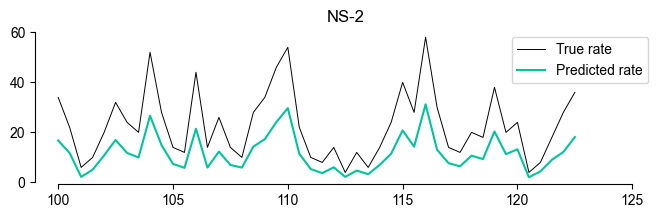

In [121]:
# plt.plot(u1_fr, color='k', label='True rate')
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(fr_time, u379fr, color='k', label='True rate', linewidth=0.7)
ax.plot(fr_time, rate_preds[:,0] + 20, color=WAVEMAP_PAL[1], label='Predicted rate')
# ax.fill_between(fr_time, rate_preds[:,0] + 20 - rate_pred_stes[:,0], rate_preds[:,0] + 20 + rate_pred_stes[:,0], color=cmap(1), alpha=0.2)
ax.set_title("NS-2")
ax.legend()
ax.set_xlim(99, 126)
ax.spines['bottom'].set_bounds(100, 125)
ax.spines['left'].set_bounds(0, 60)


In [122]:
fig.savefig('figs/ns2_ssm_frs.pdf', dpi=300)

Text(0.02, 0.5, 'Firing rate (Hz)')

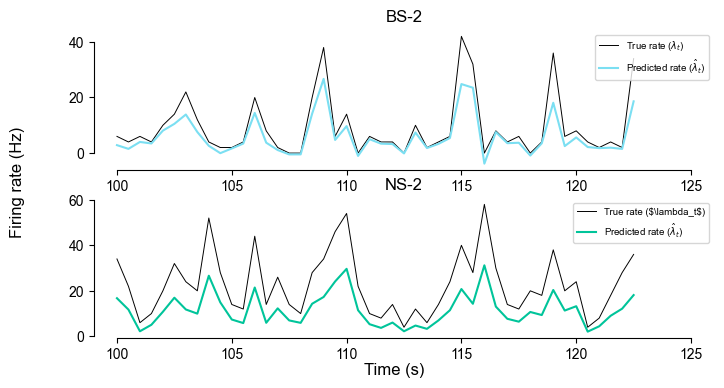

In [132]:
# plt.plot(u1_fr, color='k', label='True rate')
fig, ax = plt.subplots(2,1, figsize=(8,4))
ax[0].plot(fr_time, u383fr, color='k', label='True rate ($\lambda_t$)', linewidth=0.7)
ax[0].plot(fr_time, rate_preds[:,1] + 20, color=WAVEMAP_PAL[5], label='Predicted rate ($\hat\lambda_t$)')
# ax.fill_between(fr_time, rate_preds[:,0] + 20 - rate_pred_stes[:,0], rate_preds[:,0] + 20 + rate_pred_stes[:,0], color=cmap(1), alpha=0.2)
ax[0].set_title("BS-2")
ax[0].legend(fontsize='x-small', loc='upper right')

ax[0].set_xlim(99, 126)
ax[0].spines['bottom'].set_bounds(100, 125)
ax[0].spines['left'].set_bounds(0, 40)

ax[1].plot(fr_time, u379fr, color='k', label='True rate (\$\lambda_t$)', linewidth=0.7)
ax[1].plot(fr_time, rate_preds[:,0] + 20, color=WAVEMAP_PAL[1], label='Predicted rate ($\hat\lambda_t$)')
# ax.fill_between(fr_time, rate_preds[:,0] + 20 - rate_pred_stes[:,0], rate_preds[:,0] + 20 + rate_pred_stes[:,0], color=cmap(1), alpha=0.2)
ax[1].set_title("NS-2")
ax[1].legend(fontsize='x-small')
ax[1].set_xlim(99, 126)
ax[1].spines['bottom'].set_bounds(100, 125)
ax[1].spines['left'].set_bounds(0, 60)

fig.supxlabel('Time (s)')
fig.supylabel('Firing rate (Hz)')

In [133]:
fig.savefig('figs/ssm_frs.pdf', dpi=300)

In [70]:
rate_preds_adj = rate_preds + 20
pred_spec = rate_preds_adj @ fppssm_full.S_f_interp_list

In [73]:
obs_spec = fn.spectrafuncs.multitaper_spectrogram(ts_signal, fs, time_halfbandwidth_product=5.75, window_duration=0.5, window_step=0.5, start_time=time_window[0])

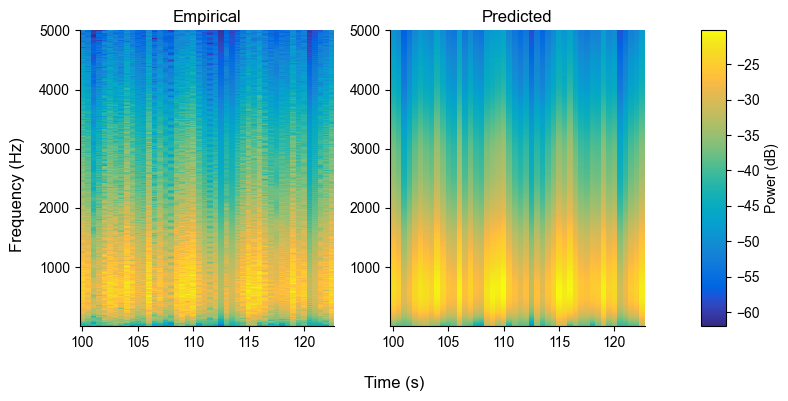

In [129]:
gridspec = {'width_ratios': [1, 1, 0.1]}
fig, ax = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw=gridspec)

im = ax[0].pcolormesh(
    obs_spec.time,
    obs_spec.frequencies,
    10 * np.log10(obs_spec.power().squeeze().T),
    cmap=ml_map,
    shading="auto",
    vmin=-62
)
ax[0].set_ylim(1,5000)
ax[0].set_title("Empirical")

im2 = ax[1].pcolormesh(
    obs_spec.time,
    fppssm_full.spectrogram_trunc_freqs,
    10 * np.log10(pred_spec.T),
    cmap=ml_map,
    shading='auto',
    vmin=-62
)
ax[1].set_ylim(1,5000)
ax[1].set_title("Predicted")

fig.tight_layout()

fig.supxlabel("Time (s)")
fig.supylabel("Frequency (Hz)")

cax = ax[2]
plt.colorbar(im2, cax=cax, label='Power (dB)')
plt.tight_layout()

In [130]:
fig.savefig("figs/ssm_spectrogram.pdf", dpi=200)